In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, datasets, transforms
from torch.autograd import grad
import torchvision

torch.manual_seed(50)

In [2]:
interval = 30
class_num = 10
protected_layers = []  # No specific layers to protect initially
dst = datasets.CIFAR10("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:4"  # Changed to cuda:0 for general usage
print("Running on %s" % device)

Files already downloaded and verified
Running on cuda:4


In [3]:
def label_to_onehot(target, num_classes=class_num):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

In [4]:
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [5]:
def weights_init(m):
  if hasattr(m, "weight"):
      m.weight.data.uniform_(-0.5, 0.5)
  if hasattr(m, "bias"):
      m.bias.data.uniform_(-0.5, 0.5)

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, class_num)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
net = LeNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

GT label is 2. 
Onehot label is 2.


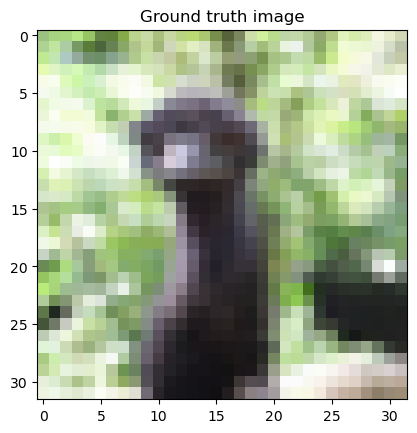

In [8]:
img_index = 55
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=class_num)
plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

In [9]:
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

In [10]:
torch.cat([g.view(-1) for g in dy_dx]).count_nonzero()

tensor(19438, device='cuda:4')

In [11]:
flattened_grads = torch.cat([g.view(-1) for g in dy_dx])
flattened_grads[-5:]

tensor([6.1626e-04, 4.2538e-05, 3.7137e-04, 1.9220e-03, 8.7746e-04],
       device='cuda:4')

In [12]:
flattened_grads[-4:]

tensor([4.2538e-05, 3.7137e-04, 1.9220e-03, 8.7746e-04], device='cuda:4')

In [13]:
flattened_grads[-3:]

tensor([0.0004, 0.0019, 0.0009], device='cuda:4')

In [14]:
total_params = len(flattened_grads)
exposed_params = int(total_params * (1/3))

In [15]:
total_params

19438

In [16]:
exposed_params

6479

In [17]:
mask = torch.zeros(total_params, device=flattened_grads.device)

In [18]:
mask[:exposed_params] = 1

In [19]:
mask.count_nonzero()

tensor(6479, device='cuda:4')

In [20]:
#mask = mask[torch.randperm(total_params)]

In [21]:
def mask_gradients(dy_dx, exposure_ratio=1/3):
    flattened_grads = torch.cat([g.view(-1) for g in dy_dx])
    total_params = len(flattened_grads)
    exposed_params = int(total_params * exposure_ratio)

    mask = torch.zeros(total_params, device=flattened_grads.device)
    mask[exposed_params:2*exposed_params] = 1

    masked_grads = []
    start = 0
    for g in dy_dx:
        numel = g.numel()
        g_flat = g.view(-1)
        masked_g_flat = g_flat * mask[start:start+numel]
        masked_grads.append(masked_g_flat.view_as(g))
        start += numel

    return tuple(masked_grads)


In [22]:
dy_dx = mask_gradients(dy_dx)

In [23]:
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

Dummy label is 7.


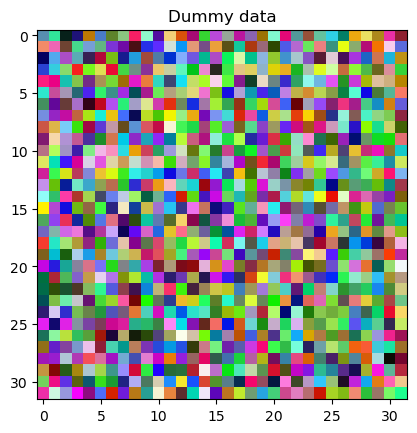

In [24]:
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [25]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

In [26]:
history = []
losses = []
for iters in range(30*interval):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        dummy_dy_dx = mask_gradients(dummy_dy_dx)

        grad_diff = 0
        grad_count = 0

        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()

        grad_diff.backward()
        losses.append(grad_diff.item())
        return grad_diff

    optimizer.step(closure)
    if iters % interval == 0:
        print(f"{iters}, {losses[iters]}")
    history.append(tt(dummy_data[0].cpu()))

0, 126.19412994384766
30, 0.7163904905319214
60, 0.17707182466983795
90, 0.09113510698080063
120, 0.06288354843854904
150, 0.04700727388262749
180, 0.03801259398460388
210, 0.030483581125736237
240, 0.026299191638827324
270, 0.020005550235509872
300, 0.017500784248113632
330, 0.01561462040990591
360, 0.014756669290363789
390, 0.01419096253812313
420, 0.01373434066772461
450, 0.013302152045071125
480, 0.012957300059497356
510, 0.012523354962468147
540, 0.012116382829844952
570, 0.01178133487701416
600, 0.011412280611693859
630, 0.01094481348991394
660, 0.01035461388528347
690, 0.009807635098695755
720, 0.009251461364328861
750, 0.008333689533174038
780, 0.007130373734980822
810, 0.00662948377430439
840, 0.006301976274698973
870, 0.00609698798507452


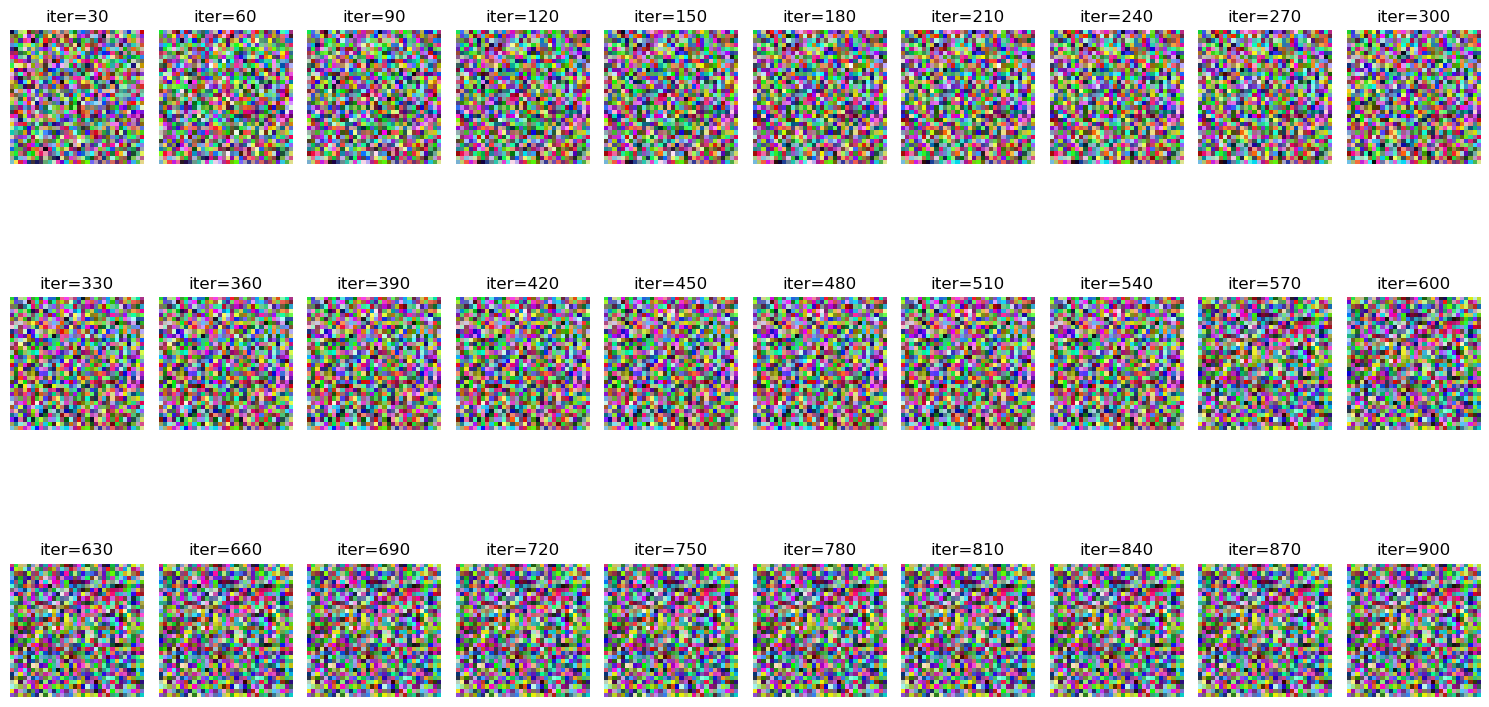

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: replace this with your actual image data
# For demonstration, let's generate 900 random images (28x28 pixels)
# history = np.random.rand(900, 28, 28)

# Set the interval
interval = 30

# Create a figure
plt.figure(figsize=(15, 9))

# Plot the images
for i in range(30):
    ite_num = i * interval + interval - 1
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[ite_num])  # Assuming the images are grayscale
    plt.title("iter=%d" % (ite_num + 1))
    plt.axis('off')
plt.tight_layout()
plt.show()

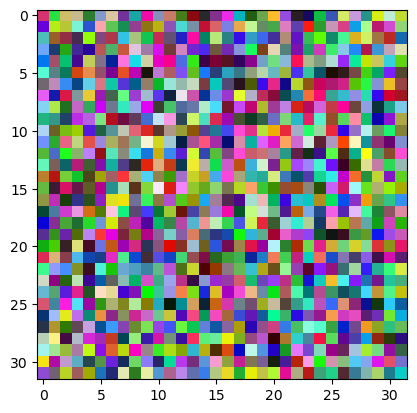

In [28]:
plt.imshow(history[869])
# plt.title("iter=%d" % (ite_num+1))
plt.show()

GT label is 2. 
Onehot label is 2.
Dummy label is 8.
0, 187.7445526123047
30, 2.8498940467834473
60, 0.9276402592658997
90, 0.36923500895500183
120, 0.17247626185417175
150, 0.12308268994092941
180, 0.09775755554437637
210, 0.0821923092007637
240, 0.06793675571680069
270, 0.05614634230732918
300, 0.0481366403400898
330, 0.04392806068062782
360, 0.039000120013952255
390, 0.03417649120092392
420, 0.031013142317533493
450, 0.028991160914301872
480, 0.027141785249114037
510, 0.02526731602847576
540, 0.02390711009502411
570, 0.02076534368097782
600, 0.01788923516869545
630, 0.016206640750169754
660, 0.01521015353500843
690, 0.01458705309778452
720, 0.01402042992413044
750, 0.013611507602036
780, 0.01329993735998869
810, 0.01294622290879488
840, 0.012506016530096531
870, 35.97616958618164
idx = 857, len = 2058
Dummy label is 3.
GT label is 2. 
Onehot label is 2.
Dummy label is 1.
0, 206.84036254882812
30, 2.302642822265625
60, 0.5913366675376892
90, 0.22617319226264954
120, 0.139171406626701

/tmp/ipykernel_165224/2601658062.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


idx = 93, len = 1026
Dummy label is 3.


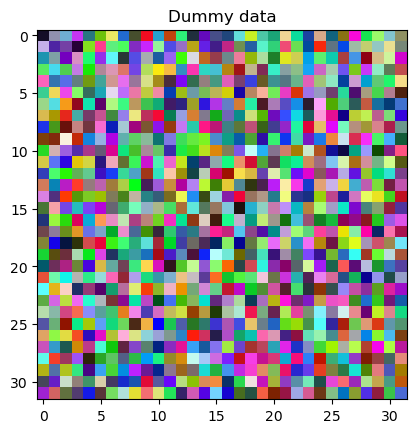

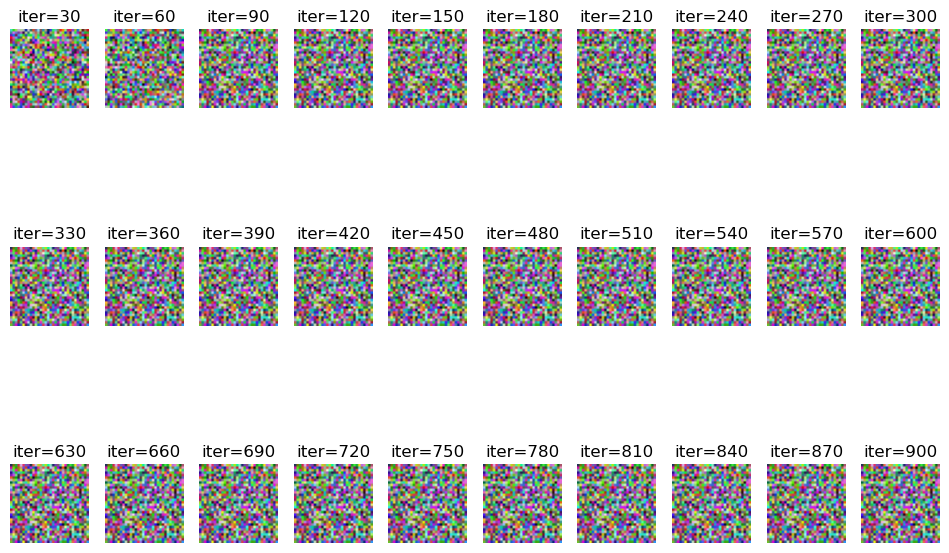

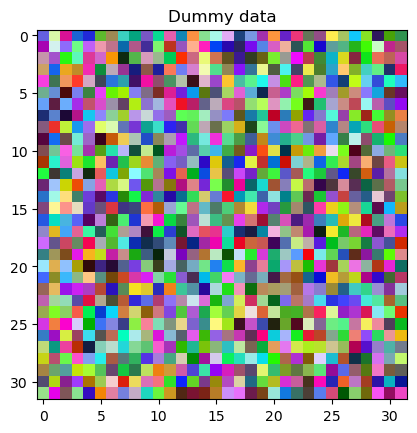

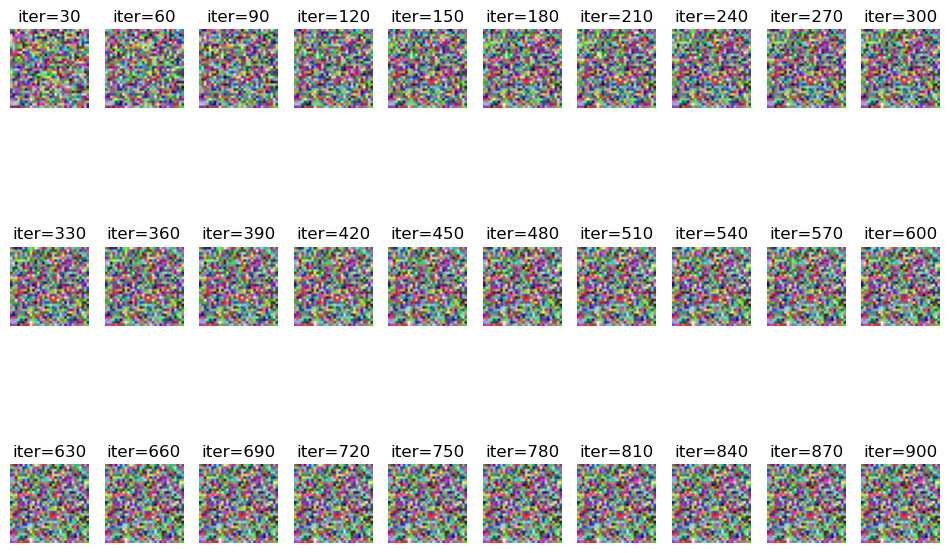

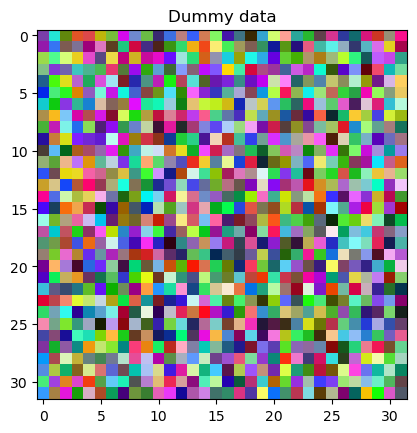

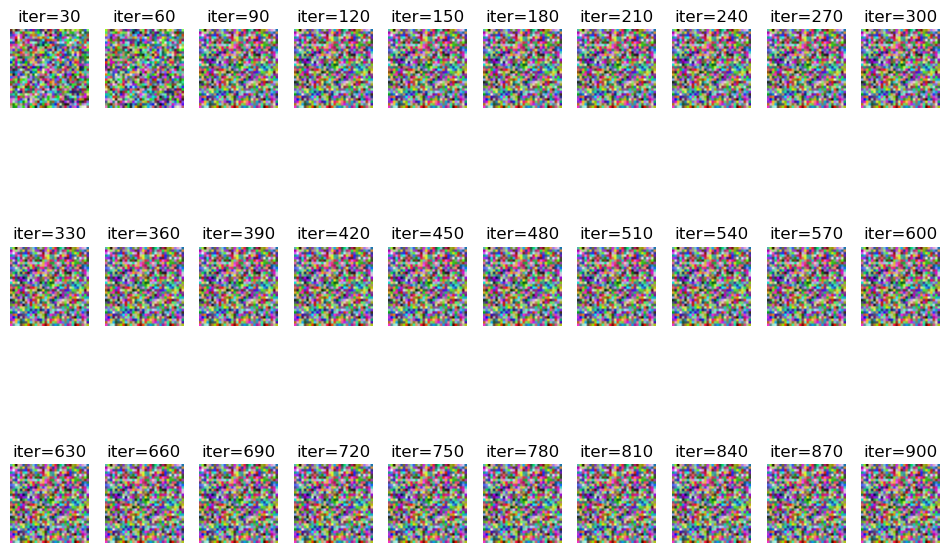

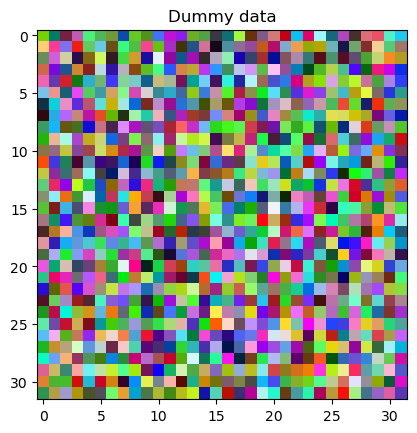

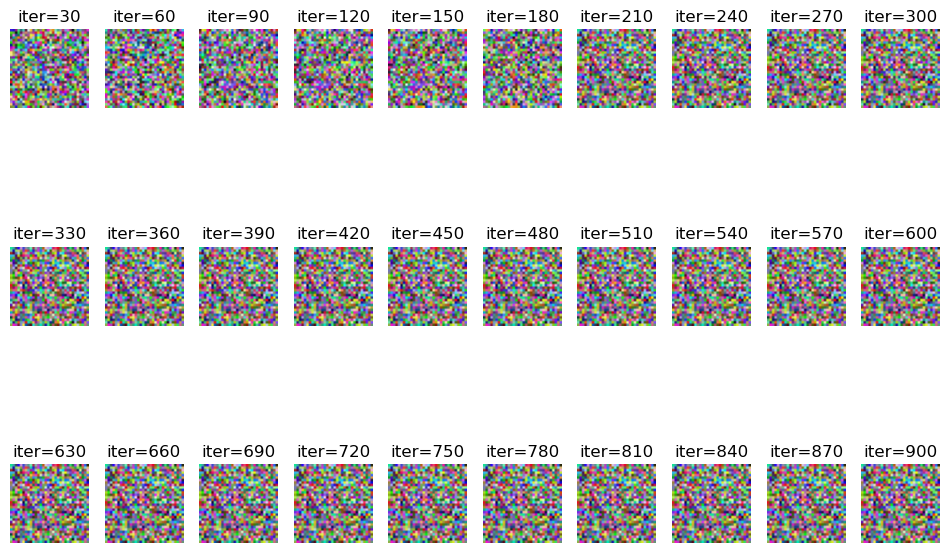

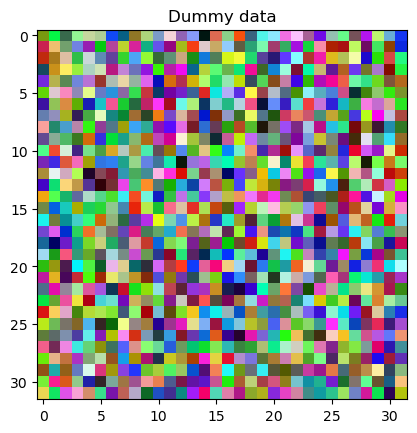

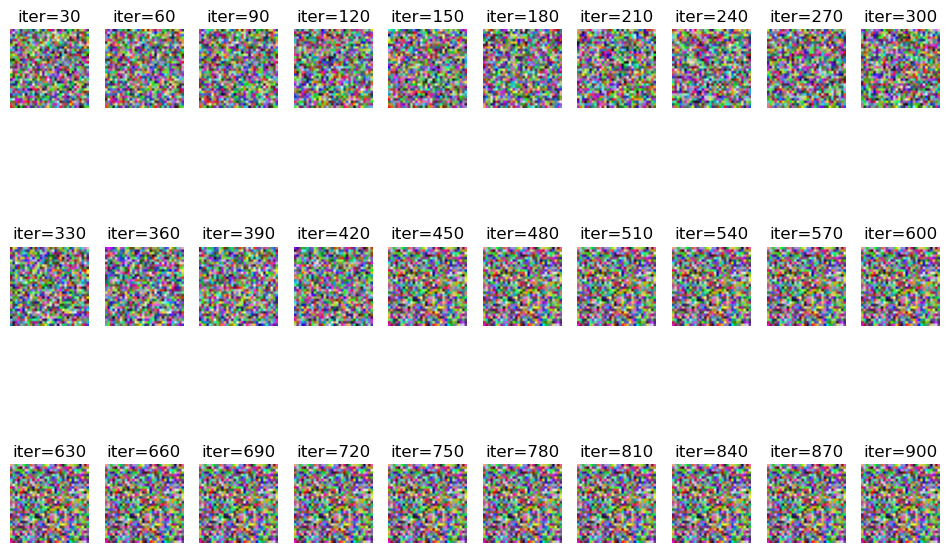

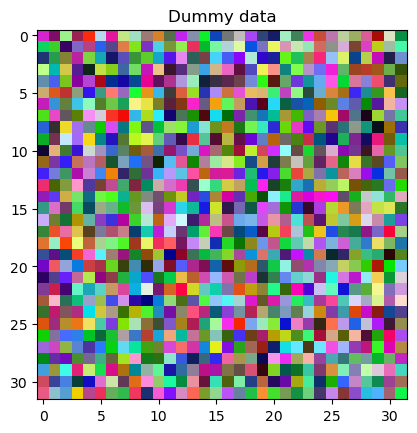

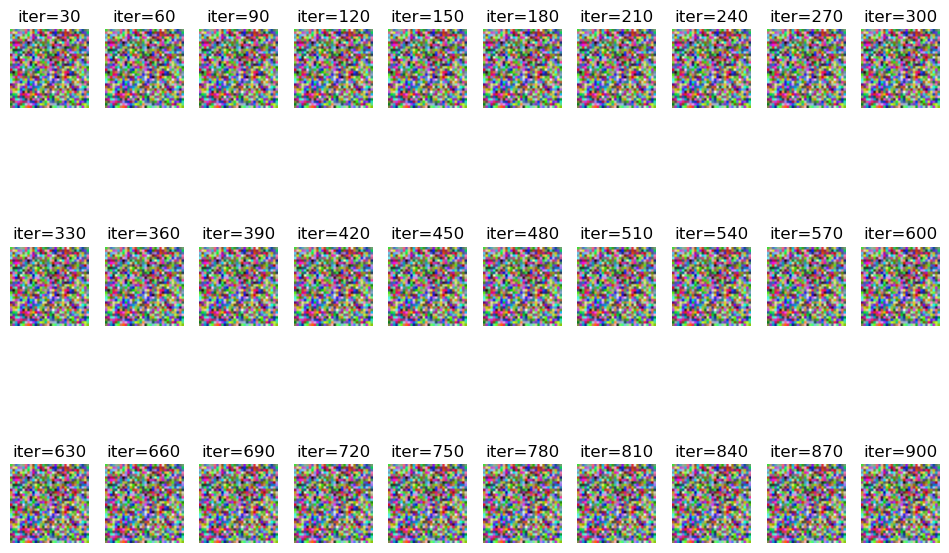

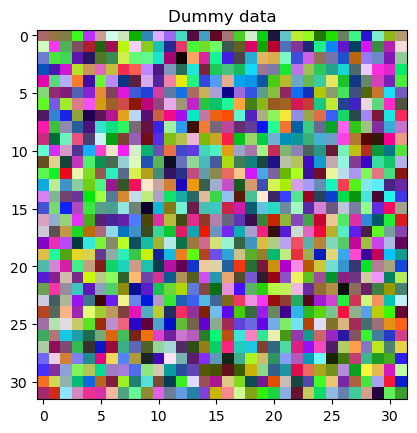

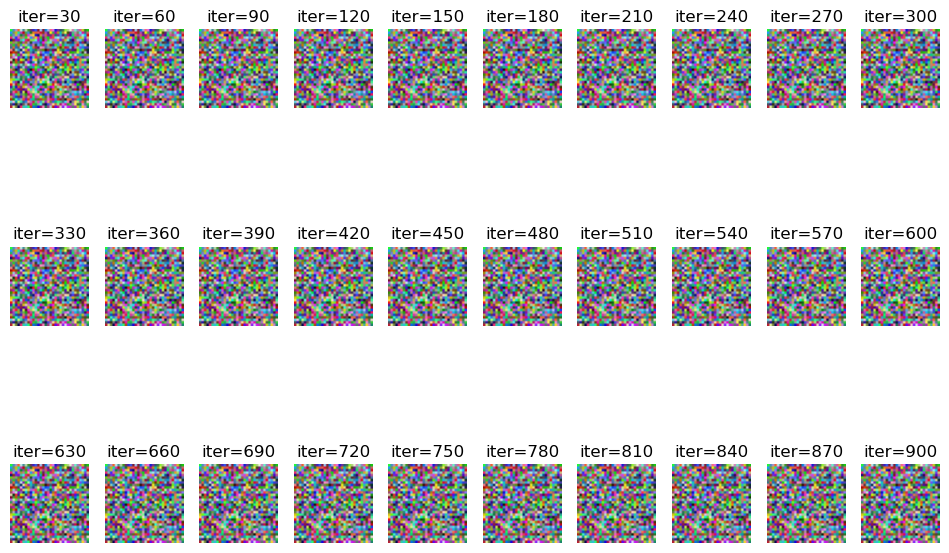

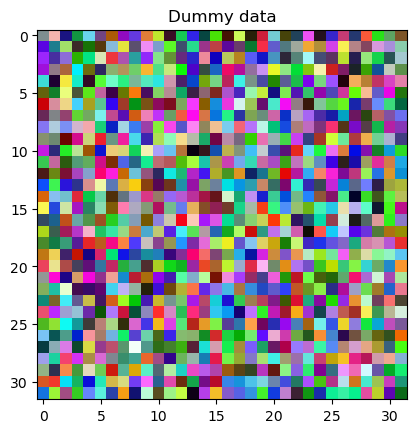

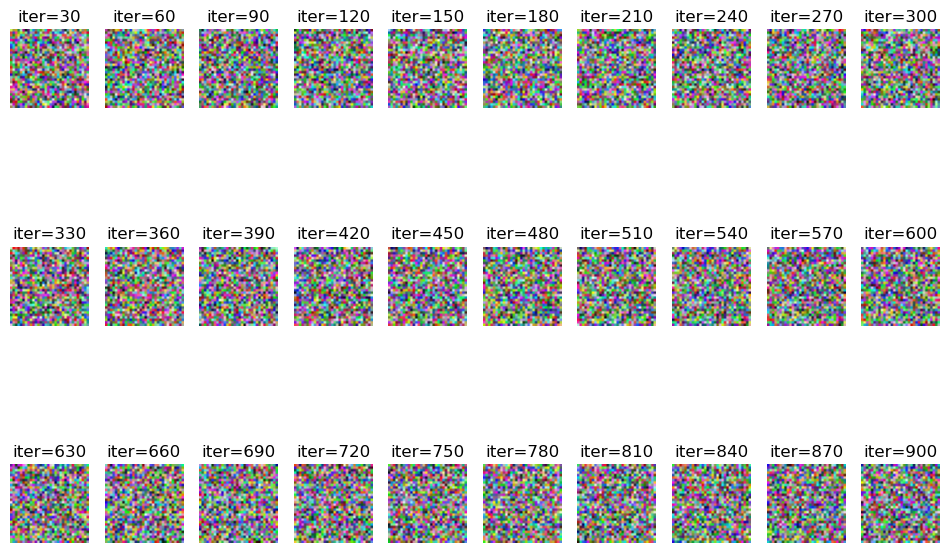

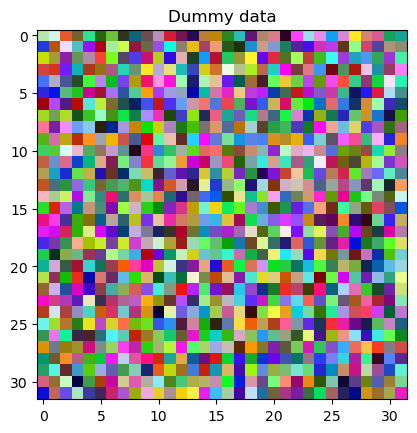

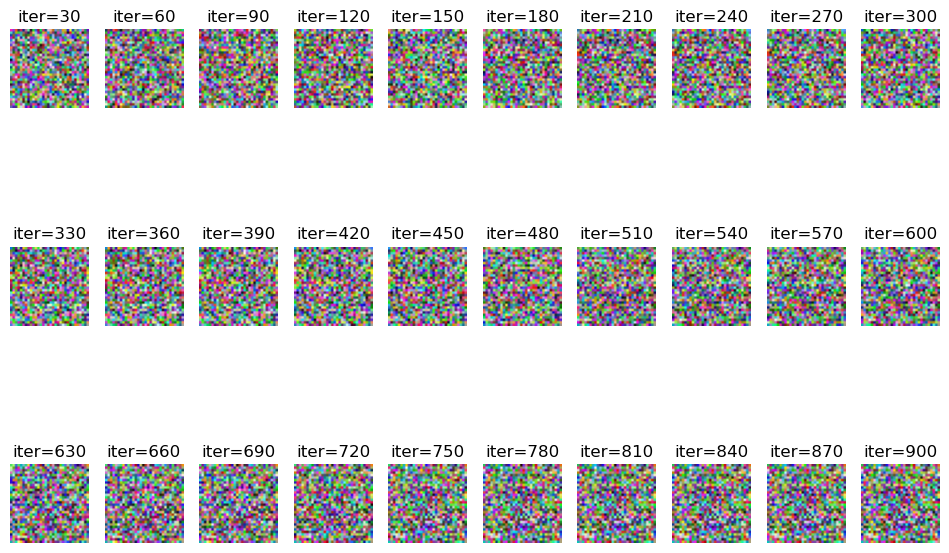

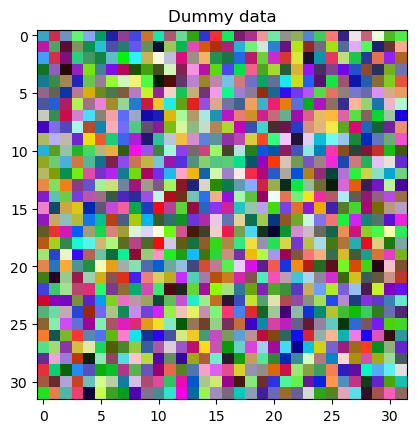

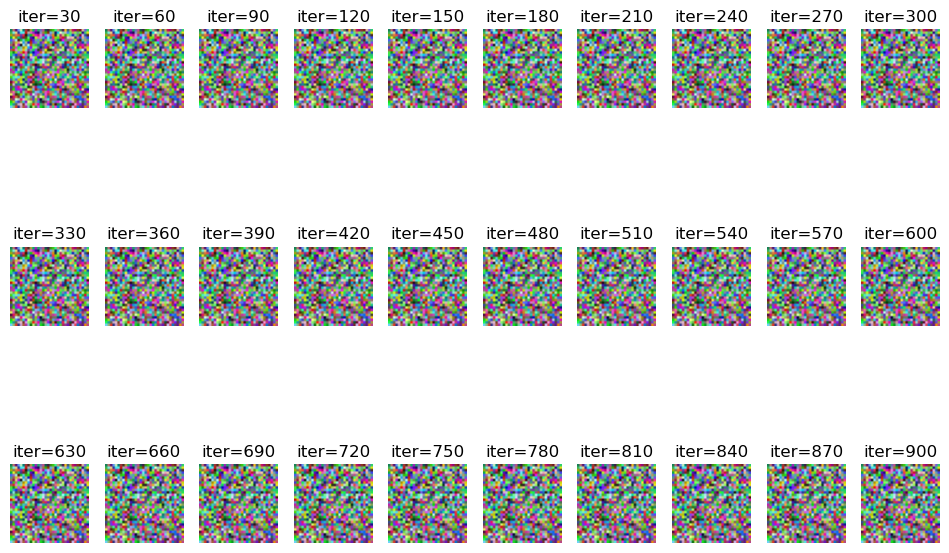

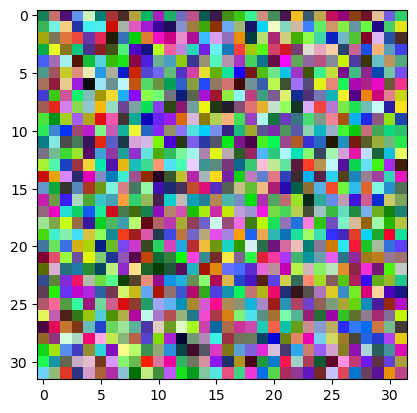

In [29]:
for tid in range(10):

    net = LeNet().to(device)

    net.apply(weights_init)
    criterion = cross_entropy_for_onehot

    img_index = 55
    gt_data = tp(dst[img_index][0]).to(device)
    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=class_num)
    plt.imshow(tt(gt_data[0].cpu()))
    plt.title("Ground truth image")
    print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    out = net(gt_data)
    y = criterion(out, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())

    dy_dx = mask_gradients(dy_dx)

    original_dy_dx = list((_.detach().clone() for _ in dy_dx))

    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

    history = []
    losses = []
    for iters in range(30*interval):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            dummy_dy_dx = mask_gradients(dummy_dy_dx)

            grad_diff = 0
            grad_count = 0

            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()

            grad_diff.backward()
            losses.append(grad_diff.item())
            return grad_diff

        optimizer.step(closure)
        if iters % interval == 0:
            print(f"{iters}, {losses[iters]}")
        history.append(tt(dummy_data[0].cpu()))

    plt.figure(figsize=(12, 8))
    for i in range(30):
        ite_num = i * interval + interval - 1
        plt.subplot(3, 10, i + 1)
        plt.imshow(history[ite_num])
        plt.title("iter=%d" % (ite_num+1))
        plt.axis('off')

    filename = 'CIFAR'+str(class_num)+'_'+ str(30*interval) + 'ite_' + str(protected_layers) + '_' +'.png'
    plt.savefig(filename)

    plt.figure()
    loss = min(losses[0:interval * 30 - 1])
    idx = losses.index(loss)
    print(f"idx = {idx}, len = {len(losses)}")
    plt.imshow(history[idx])
    filename = 'single_' + filename
    plt.savefig(filename)

    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())


GT label is 2. 
Onehot label is 2.


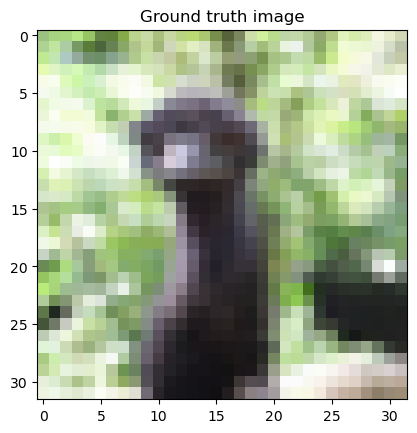

In [30]:
plt.imshow(tt(gt_data[0].cpu()))
# file_gt = "gt.png"
# plt.savefig(file_gt)
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())